<a href="https://colab.research.google.com/github/Phrmth/New/blob/master/Neural_Net_from_scratch_on_Boston_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# import packages 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch import tensor
from torch import nn
import torch.nn.functional as F
import torch
from torch import optim

from torch.utils.data import DataLoader, TensorDataset

In [85]:
# Data

from sklearn.datasets import load_boston

X, y = load_boston(return_X_y=True)
X = torch.from_numpy(X.astype(np.float32)); y = torch.from_numpy(y.astype(np.float32)); X.shape, y.shape

# Creating train and validation dataset
x_train  = X[50:506]; x_valid = X[0:50] ; y_train = y[50:506]; y_valid = y[0:50]
x_train.shape,y_train.shape,x_valid.shape, y_valid.shape

(torch.Size([456, 13]),
 torch.Size([456]),
 torch.Size([50, 13]),
 torch.Size([50]))

In [0]:
# Normalizing with train data's mean and std 

def normalize(x, valid = None, test = None ):
  x_mean = x.mean(dim = 0)
  x_std = x.std(dim = 0 ) 
  if test : x = valid
  return (x - x_mean)/x_std

In [0]:
# Normalizing train and valid dataset
x_norm = normalize(x_train); x_valid= normalize(x_train,x_valid,True)
x_norm.shape, x_valid.shape

dl_train = DataLoader(TensorDataset(x_norm, y_train.view(-1,1)), batch_size = 25, shuffle = True)
dl_valid = DataLoader(TensorDataset(x_valid, y_valid.view(-1,1)), batch_size = len(x_valid), shuffle = False)

In [74]:
y.mean(),y_valid.mean()

(tensor(22.5328), tensor(20.5020))

In [0]:
if torch.cuda.is_available():
 device = torch.device("cuda")
else : device = torch.device("cpu")

In [0]:
m = x_train.shape[1]
nh = 10
lr = 1e-3
loss_func = nn.MSELoss()
def get_model():
  Model = nn.Sequential(nn.Linear(m,nh),
                        nn.ReLU(),
                        nn.Linear(nh,nh),
                        nn.ReLU(),
                        nn.Linear(nh,1)
                        )
  return Model, optim.Adam(Model.parameters(), lr=lr, eps = 1e-7, weight_decay= .01 )


model, opt = get_model()

from torch.nn import init

for l in model:
  if isinstance(l, nn.Linear):
    init.kaiming_normal_(l.weight)

In [0]:
def fit(epoch, model , dl_train, dl_valid, opt, loss_func ):
  train_loss = []
  valid_loss = []
  loss1 = []
  loss2 = []
  model.to(device)
  for l in range(epoch):
    
    for xb, yb in dl_train:

      model.train()
      opt.zero_grad()
      xb,yb = xb.to(device),yb.to(device)
      pred = model(xb)
      loss = loss_func(pred,yb)
      loss.backward()
      opt.step()

    train_loss.append(loss)
      # with torch.no_grad():
      #   for p in model.parameters(): p-= p.grad * lr
    if (l+1) % 10 == 0: 
      print(f"Epoch{l} : Train Loss {loss.item()} ")# , Valid Loss {loss_v.item()}")
  
  with torch.no_grad():
      for xv,yv in dl_valid:
        
        xv,yv = xv.to(device),yv.to(device)
        pred = model(xv)
        loss_v = loss_func(pred,yv)

        loss2.append(loss_v)
        print(loss_v)
    
  return train_loss#, valid_loss


Losses per batch for every 10th epoch ! 


In [136]:
loss = fit(100, model, dl_train, dl_valid, opt, loss_func)

Epoch9 : Train Loss 110.72615814208984 
Epoch19 : Train Loss 21.5073299407959 
Epoch29 : Train Loss 40.345191955566406 
Epoch39 : Train Loss 38.44336700439453 
Epoch49 : Train Loss 16.105764389038086 
Epoch59 : Train Loss 7.685610771179199 
Epoch69 : Train Loss 3.8384604454040527 
Epoch79 : Train Loss 33.49188995361328 
Epoch89 : Train Loss 5.657668113708496 
Epoch99 : Train Loss 7.221421718597412 
tensor(11.2670, device='cuda:0')


Text(0, 0.5, 'Loss')

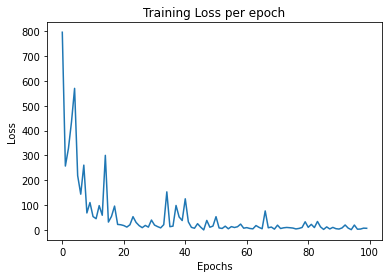

In [144]:
plt.plot(range(100),loss)
#plt.plot(range(100),loss_v)
plt.title("Training Loss per epoch")
plt.xlabel('Epochs')
plt.ylabel('Loss')

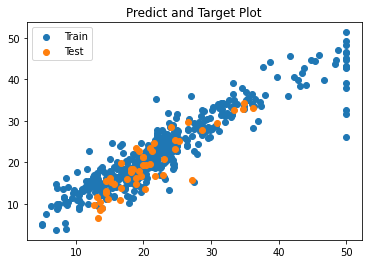

In [138]:
model = model.to('cpu')
predicted = model(x_norm).detach().numpy()
plt.scatter(y_train, predicted, label='Train')
plt.scatter(y_valid, model(x_valid).detach().numpy(), label='Test')

plt.title('Predict and Target Plot')
plt.legend(loc="upper left")